<a href="https://colab.research.google.com/github/MuhammadBilal848/Deep-Learning-Practice/blob/main/Transfer%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras 
import cv2 as cv
import PIL 
import os
import tensorflow_hub as hub
import pathlib
from sklearn.model_selection import train_test_split

#### The pre-trained model is taken from Tensorflow Hub : https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4
#### This model has 1001 classes : https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt

In [48]:
m = (5,5)
m

(5, 5)

In [49]:
m+(3,)

(5, 5, 3)

In [50]:
inp_shp = (224,224) # mobileNet_v2 expects 224x224 input image
mbl = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=inp_shp+(3,))
])

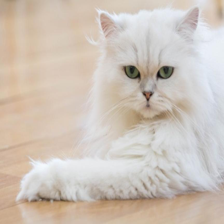

In [51]:
persian_cat = PIL.Image.open('/content/drive/MyDrive/Colab Notebooks/p cat.jpg').resize(inp_shp)
persian_cat

In [52]:
persian_cat = np.array(persian_cat)/255
persian_cat.shape

(224, 224, 3)

In [100]:
persian_cat[np.newaxis, ...].shape
# new axis here is representing the "Batch Size", here it is one bcz we want to predict only one image.

(1, 224, 224, 3)

In [57]:
np.argmax(mbl.predict(persian_cat[np.newaxis, ...]))

1/1 [==============================] - 0s 56ms/step


284

In [63]:
with open('/content/drive/MyDrive/Colab Notebooks/ImageNetLabels.txt','r') as f:
  imgname = f.read().splitlines()
imgname[284]

'Persian cat'

#### Now we apply this pre-trained model on the flower dataset for data augmentation.

In [65]:
dataset = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
data = keras.utils.get_file('flower_photos', origin=dataset,  cache_dir='/content/drive/MyDrive/Colab Notebooks', untar=True)
# cache_dir : when we set it to '.' the dataset is saved where the file is saved.
# untar = True , is used for unzipping.

In [66]:
data = pathlib.Path(data) # this converts the data path into windows path
data

PosixPath('/content/drive/MyDrive/Colab Notebooks/datasets/flower_photos')

In [67]:
images = list(data.glob('*/*.jpg')) # this returns the list of all the images available by going into directories n subdirectories.
img_count = len(list(data.glob('*/*.jpg')))

In [69]:
flowers_dict = {
              'roses':list(data.glob('roses/*')),
              'daisy':list(data.glob('daisy/*')),
              'dandelion':list(data.glob('dandelion/*')),
              'sunflowers':list(data.glob('sunflowers/*')),
              'tulips':list(data.glob('tulips/*'))  
               }
flowers_name = {
              'roses':0,
              'daisy':1,
              'dandelion':2,
              'sunflowers':3,
              'tulips':4  
               }

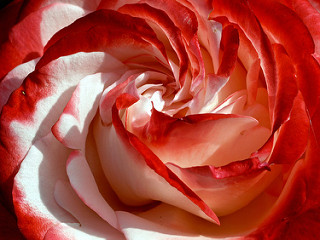

In [74]:
PIL.Image.open(flowers_dict['roses'][45])

In [76]:
x,y = [],[]
for name,flower in flowers_dict.items():
  for flov in flower:
    img = cv.imread(str(flov))
    resize = cv.resize(img, (224,224))
    x.append(resize)
    y.append(flowers_name[name])

In [80]:
x = np.array(x)
y = np.array(y)

In [118]:
xtrain , xtest , ytrain , ytest = train_test_split(x,y,test_size=0.2)

In [119]:
xtrain = xtrain/255
xtest = xtest/255

In [96]:
mbl.predict(np.array([x[56]]))  # np.array(x[56]) this helps add another dimension that we added in the persian cat array using newaxis

1/1 [==============================] - 0s 107ms/step


array([[ 0.16966209, -0.7966896 ,  1.2036455 , ..., -1.052162  ,
        -0.25176427,  3.7770672 ]], dtype=float32)

In [124]:
mbl.predict(np.array([x[595],x[3200]]))

1/1 [==============================] - 0s 83ms/step


array([[ 0.25014475, -0.22856842, -0.08154811, ..., -2.009565  ,
        -1.2829442 ,  2.003975  ],
       [ 0.4386386 ,  2.0134177 ,  2.1488624 , ..., -0.67644465,
        -0.8467147 ,  2.5444517 ]], dtype=float32)

In [125]:
np.argmax(mbl.predict(np.array([x[595],x[3200]])),axis = 1)

1/1 [==============================] - 0s 94ms/step


array([722, 795])

### We can observe that model is randomly predicting the images out of those 1000 classes of mobilenet.

In [128]:
imgname[722] , imgname[795]

('pillow', 'shower curtain')

#### Now we will use Transfer Learning and for this we will use feature extractor model : https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4

In [131]:
fem = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

model_without_output_layer = keras.Sequential([
                  hub.KerasLayer(fem , input_shape = (224,224,3) , trainable = False), # trainable = False means do not train hidden layers or freeze them. 
                  keras.layers.Dense(5,activation = 'softmax') # 5 is the no of flower categories we have
])

In [134]:
model_without_output_layer.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_7 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [136]:
model_without_output_layer.compile(optimizer = 'adam',loss = 'sparse_categorical_crossentropy',metrics = 'Accuracy')
model_without_output_layer.fit(xtrain,ytrain,epochs = 5)  

Epoch 1/5
92/92 [==============================] - 109s 1s/step - loss: 0.8053 - Accuracy: 0.6982
Epoch 2/5
92/92 [==============================] - 100s 1s/step - loss: 0.4074 - Accuracy: 0.8542
Epoch 3/5
92/92 [==============================] - 100s 1s/step - loss: 0.3158 - Accuracy: 0.8985
Epoch 4/5
92/92 [==============================] - 100s 1s/step - loss: 0.2651 - Accuracy: 0.9169
Epoch 5/5
92/92 [==============================] - 102s 1s/step - loss: 0.2326 - Accuracy: 0.9326


#### We can see that with pretrained model we got the accuracy of 87%

In [137]:
model_without_output_layer.evaluate(xtest,ytest)

23/23 [==============================] - 27s 1s/step - loss: 0.3567 - Accuracy: 0.8760


[0.35671597719192505, 0.8760218024253845]